In [1]:
# unique token for this session 
SESSION_TOKEN = 'simple_gossip_example'

In [2]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
from graphviz import Digraph
from consensus_simple.train_consensus import main, get_train_loaders
from resnet import resnet20

In [3]:
# set your paths for loading dataset and stats saving
BASE_DIR = Path().cwd()

SAVE_DIR = BASE_DIR.joinpath('stat_dir').joinpath(SESSION_TOKEN)
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DATASET_NAME = 'cifar10'
DATASET_DIR = BASE_DIR.parent / 'distributed-learning' / 'data' / DATASET_NAME

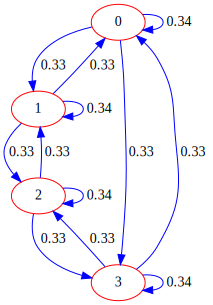

In [4]:
n_agents = 4

topology = {
    0: {0: 0.34, 
        1: 0.33,
        3: 0.33,
       },
    1: {1: 0.34, 
        0: 0.33,
        2: 0.33,
       },
    2: {2: 0.34, 
        1: 0.33,
        3: 0.33,
       },
    3: {3: 0.34, 
        2: 0.33,
        0: 0.33,
       },
}

g = Digraph(name='topology', directory=SAVE_DIR)
g.attr('node', color='red')
g.attr('edge', color='blue')
g.attr(size='8,5')

for agent, neighbors in topology.items():
    g.node(str(agent))
    for neighbor, w in neighbors.items():
        g.edge(str(neighbor), str(agent), label="{:.02f}".format(w))
g.save()
g

In [5]:
def get_logger(log_file_path='logs.log'):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)

    fh = logging.FileHandler(log_file_path)
    fh.setLevel(logging.INFO)

    ch = logging.StreamHandler()
    #ch.setLevel(logging.DEBUG)
    ch.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)

    logger.addHandler(fh)
    logger.addHandler(ch)

    return logger

In [6]:
dataset_sizes = {agent_name: int(50000/len(topology)) for agent_name in topology}
print(sum(dataset_sizes.values()))

train_freqs = {agent_name: 1 for agent_name in topology}
consensus_freqs = 1 # train_freqs

50000


In [7]:
train_batch_size = 32

In [8]:
_train_loaders = get_train_loaders({
    'dataset_dir': DATASET_DIR,
    'dataset_sizes': dataset_sizes,
    'train_batch_size': train_batch_size,
    'dataset_name': DATASET_NAME,
})

epoch_size = 0

print('Info about future train loaders:')
for agent_name, loader in _train_loaders.items():
    epoch_size = max(epoch_size, len(loader))
    print('For {} agent {} batches'.format(agent_name, len(loader)))

print('\nEpoch size = {} batches'.format(epoch_size))

Files already downloaded and verified
Info about future train loaders:
For 0 agent 391 batches
For 1 agent 391 batches
For 2 agent 391 batches
For 3 agent 391 batches

Epoch size = 391 batches


In [9]:
def lr_schedule(iteration):
    factor = args['n_agents'] if args['use_lsr'] else 1.0
    if iteration < epoch_size*5:  # gradual warmup
        factor = factor*iteration/(391*5)
    if iteration >= epoch_size*81:
        factor /= 10
    if iteration >= epoch_size*122:
        factor /= 10
    return factor

In [10]:
args = {
    'dataset_name': DATASET_NAME,
    'dataset_dir': DATASET_DIR,
    
    # путь до папки куда сохраняется статистика
    'save_path': SAVE_DIR,

    'train_batch_size': train_batch_size,
    'test_batch_size': 128,

    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'lr_schedule': lr_schedule,
    
    'topology': topology,
    'n_agents': len(topology),
    
    # True, если хотим перед обучением параметры всех агентов сделать идентичными 
    'equalize_start_params': True,

    # True если хотим learning_rate умножить на количество агентов в сети
    'use_lsr': True,
    
    # Задает количество итераций.
    # Если <= 200, то считается количеством эпох
    # и в этом случае умножается на размер самого большого куска датасета. 
    'num_epochs': 1,
    
    # Частота обучения одного батча для каждого агента. Измеряется в батчах.
    'train_freqs': train_freqs, 
    
    # Частота усреднения параметров для каждого агента. Измеряется в батчах.
    # Если хочется усредняться после каждого батча, должно быть равным train_freqs
    'consensus_freqs': consensus_freqs,
    
    # Частота сбора статистики. Измеряется в батчах.
    'stat_freq': epoch_size,
    
    # Количество данных для каждого агента. 
    # Значения должны суммироваться к размеру датасета. Для cifar10 это 50000. 
    'dataset_sizes': dataset_sizes,

    'model': resnet20,
    
    'gossip_args': {'times': 1, 'neighbors_num': 1},
    
    #'checkpoint_path': SAVE_DIR,
}

args['logger'] = get_logger(log_file_path=SAVE_DIR.joinpath('logs.log'))

In [11]:
main(args)

2021-06-03 01:21:19,189 - __main__ - INFO - START with args 
{'dataset_name': 'cifar10', 'dataset_dir': PosixPath('/home/sergey/Documents/homeworks/distrib_learning/distributed-learning/data/cifar10'), 'save_path': PosixPath('/home/sergey/Documents/homeworks/distrib_learning/pytorch_resnet_cifar10/stat_dir/simple_gossip_example'), 'train_batch_size': 32, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': <function lr_schedule at 0x7f9a19b0aaf0>, 'topology': {0: {0: 0.34, 1: 0.33, 3: 0.33}, 1: {1: 0.34, 0: 0.33, 2: 0.33}, 2: {2: 0.34, 1: 0.33, 3: 0.33}, 3: {3: 0.34, 2: 0.33, 0: 0.33}}, 'n_agents': 4, 'equalize_start_params': True, 'use_lsr': True, 'num_epochs': 1, 'train_freqs': {0: 1, 1: 1, 2: 1, 3: 1}, 'consensus_freqs': 1, 'stat_freq': 391, 'dataset_sizes': {0: 12500, 1: 12500, 2: 12500, 3: 12500}, 'model': <function resnet20 at 0x7f9a19b03ca0>, 'gossip_args': {'times': 1, 'neighbors_num': 1}, 'logger': <Logger __main__ (DEBUG)>}
2021-06-03 01:

Files already downloaded and verified


2021-06-03 01:21:20,625 - __main__ - INFO - Train loaders successfully prepared
2021-06-03 01:21:22,710 - __main__ - INFO - 4 Models successfully prepared
2021-06-03 01:21:22,713 - __main__ - INFO - Preparing took 0:00:03
2021-06-03 01:21:23,168 - __main__ - INFO - Agent 0 successfully prepared
2021-06-03 01:21:23,232 - __main__ - INFO - Agent 1 successfully prepared
2021-06-03 01:21:23,267 - __main__ - INFO - Agent 2 successfully prepared
2021-06-03 01:21:23,314 - __main__ - INFO - Agent 3 successfully prepared
2021-06-03 01:21:23,316 - __main__ - INFO - Training started from 1 iteration
2021-06-03 01:22:27,301 - __main__ - INFO - StatisticCollector 0 add train_loss with value 0.05917524515151978
2021-06-03 01:22:27,313 - __main__ - INFO - StatisticCollector 0 add train_precision with value 31.24799919128418
2021-06-03 01:22:27,313 - __main__ - INFO - StatisticCollector 0 add lr with value 0.07979539641943734
2021-06-03 01:22:27,340 - __main__ - INFO - StatisticCollector 1 add train_l